# 02. Predicting Anime Scores

In this notebook, we will prepare features, split the data, train baseline regression models, and evaluate their performance.

---

## 1. Load Cleaned Dataset

In [11]:
import pandas as pd

# Load the processed dataset
df = pd.read_csv("../data/processed/clean_anime_full.csv")
df.head()

,title,type,source,episodes,status,rating,score,scored_by,rank,popularity,members,favorites,year,season,has_year,has_season,genres,demographics
0,Sousou no Frieren,Tv,Manga,28,Finished Airing,PG-13 - TEENS 13 OR OLDER,9.30,686846.0,1,139,1157346,71546,2023,Fall,1,1,"Adventure, Drama, Fantasy",Shounen
1,Fullmetal Alchemist: Brotherhood,Tv,Manga,64,Finished Airing,R - 17+ (VIOLENCE & PROFANITY),9.10,2227771.0,2,3,3539957,234693,2009,Spring,1,1,"Action, Adventure, Drama, Fantasy",Shounen
2,Steins;Gate,Tv,Visual Novel,24,Finished Airing,PG-13 - TEENS 13 OR OLDER,9.07,1470245.0,3,14,2711161,196638,2011,Spring,1,1,"Drama, Sci-Fi, Suspense",NaN
3,Shingeki no Kyojin Season 3 Part 2,Tv,Manga,10,Finished Airing,R - 17+ (VIOLENCE & PROFANITY),9.05,1705642.0,4,21,2462353,61277,2019,Spring,1,1,"Action, Drama, Suspense",Shounen
4,Gintama°,Tv,Manga,51,Finished Airing,PG-13 - TEENS 13 OR OLDER,9.05,264741.0,5,342,670599,17213,2015,Spring,1,1,"Action, Comedy, Sci-Fi",Shounen


---

## 2. Feature Engineering
- Drop unused or redundant columns (title, favorites, etc.)
- Encode categorical columns (type, source, etc.)
- Scale numerical features.

In [12]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

# Drop unused or redundant columns
df = df.drop(columns=["title", "favorites", "has_year", "has_season"])

# Encode categorical features
categorical_cols = ["type", "source", "status", "rating", "season", "genres", "demographics"]
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
df[categorical_cols] = encoder.fit_transform(df[categorical_cols])

# Define features and target
X = df.drop(columns=["score"])
y = df["score"]

# Scale numeric features
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

---

## 3. Train-Test Split
We split the dataset into training and testing sets using an 80:20 ratio to evaluate model performance on unseen data.

In [13]:
from sklearn.model_selection import train_test_split

# 80:20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

---

## 4. Train Baseline Models
- Linear Regression
- Random Forest

In [14]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Impute missing values with mean
# "NOTE: temporarily handled here. Will be moved to preprocessing during final refactoring."
imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_imputed, y_train)

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_imputed, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


---

## 5. Evaluate Models
- Use MAE, RMSE, R²

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import numpy as np

def evaluate_model(name, y_true, y_pred):
    print(f"{name} Evaluation")
    print(f"MAE  : {mean_absolute_error(y_true, y_pred):.4f}")
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE : {rmse:.4f}")
    print(f"R²   : {r2_score(y_true, y_pred):.4f}")
    print("-" * 30)

# Predictions
y_pred_lr = lr.predict(X_test_imputed)
y_pred_rf = rf.predict(X_test_imputed)

# Evaluation
evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Random Forest", y_test, y_pred_rf)

Linear Regression Evaluation
MAE  : 1.5690
RMSE : 2.1614
R²   : 0.6410
------------------------------
Random Forest Evaluation
MAE  : 0.0543
RMSE : 0.1830
R²   : 0.9974
------------------------------


---

## 7. Check for Overfitting
- Compare training vs testing performance
- Visualize predicted vs actual values

=== R² Comparison ===
Training R²: 0.9996
Testing R² : 0.9974

=== RMSE Comparison ===
Training RMSE: 0.0719
Testing RMSE : 0.1830


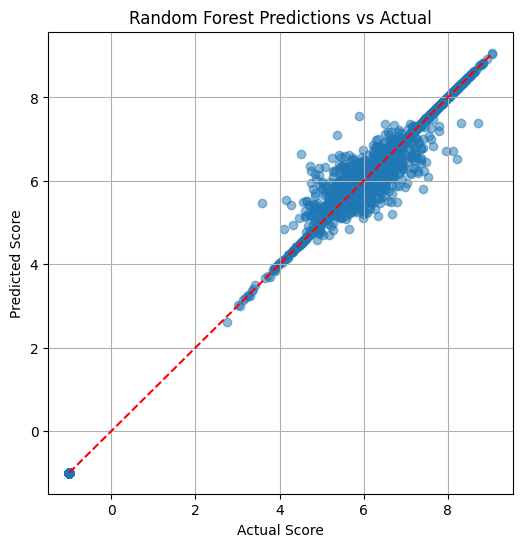

In [20]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Predict on training set
y_train_pred_rf = rf.predict(X_train_imputed)

# Training vs Testing R²
train_r2 = r2_score(y_train, y_train_pred_rf)
test_r2 = r2_score(y_test, y_pred_rf)

print("=== R² Comparison ===")
print(f"Training R²: {train_r2:.4f}")
print(f"Testing R² : {test_r2:.4f}")

# RMSE comparison
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("\n=== RMSE Comparison ===")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Testing RMSE : {test_rmse:.4f}")

# Scatter Plot: Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Random Forest Predictions vs Actual")
plt.grid(True)
plt.show()